# Preparing a Librespeech Dataloader

This notebook implements a dataloader for the Librespeech dataset.

In [1]:
import os
import pathlib
from functools import partial
from tqdm.notebook import tqdm

from pathlib import Path
from pyprojroot import here

import librosa
import librosa.display
import IPython.display as ipd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from deepspeech.utils import multicore_apply

In [2]:
! ls ../data/LibriSpeech/dev-clean/*/*/*.trans.txt | head -n 1 | xargs cat

1272-128104-0000 MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL
1272-128104-0001 NOR IS MISTER QUILTER'S MANNER LESS INTERESTING THAN HIS MATTER
1272-128104-0002 HE TELLS US THAT AT THIS FESTIVE SEASON OF THE YEAR WITH CHRISTMAS AND ROAST BEEF LOOMING BEFORE US SIMILES DRAWN FROM EATING AND ITS RESULTS OCCUR MOST READILY TO THE MIND
1272-128104-0003 HE HAS GRAVE DOUBTS WHETHER SIR FREDERICK LEIGHTON'S WORK IS REALLY GREEK AFTER ALL AND CAN DISCOVER IN IT BUT LITTLE OF ROCKY ITHACA
1272-128104-0004 LINNELL'S PICTURES ARE A SORT OF UP GUARDS AND AT EM PAINTINGS AND MASON'S EXQUISITE IDYLLS ARE AS NATIONAL AS A JINGO POEM MISTER BIRKET FOSTER'S LANDSCAPES SMILE AT ONE MUCH IN THE SAME WAY THAT MISTER CARKER USED TO FLASH HIS TEETH AND MISTER JOHN COLLIER GIVES HIS SITTER A CHEERFUL SLAP ON THE BACK BEFORE HE SAYS LIKE A SHAMPOOER IN A TURKISH BATH NEXT MAN
1272-128104-0005 IT IS OBVIOUSLY UNNECESSARY FOR US TO POINT OUT HOW LUMINOUS THESE CRITICI

In [3]:
%%time
from_scratch = True
transcripts_csv_file = here('data/LibriSpeech/transcripts.csv')
if from_scratch or not transcripts_csv_file.exists():
    dataset_dir = here('data/LibriSpeech')
    transcript_files = list(Path(dataset_dir).glob('*/*/*/*.trans.txt'))
    transcripts = []
    
    def clean_transcript(transcript):
        transcript = transcript.strip()
        transcript = transcript.replace("'", "")
        return transcript

    def process_transcripts(transcript_file):
        transcripts = []
        with open(transcript_file, 'r') as f:
            for line in f.readlines():
                audio_id, transcript = line.split(' ', 1)
                audio_file = transcript_file.parent / (audio_id + '.flac')
                audio, sample_rate = librosa.load(audio_file)
                transcripts.append({
                    'audio_id': audio_id,
                    'transcript': clean_transcript(transcript),
                    'audio_file': audio_file,
                    'sample_rate': sample_rate,
                    'audio_length': len(audio)
                })
        return transcripts            

    file_transcripts = multicore_apply(transcript_files, process_transcripts)
    df = pd.DataFrame([transcript for file in file_transcripts for transcript in file])
    df.to_csv(transcripts_csv_file, index=False)

df = pd.read_csv(transcripts_csv_file)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 769/769 [12:27<00:00, 1.03it/s]
769it [00:00, 335317.58it/s]


CPU times: user 1.94 s, sys: 266 ms, total: 2.2 s
Wall time: 12min 27s


<AxesSubplot:>

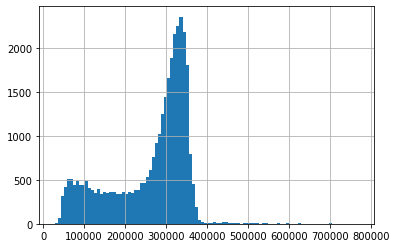

In [25]:
df.audio_length.hist(bins=100)

<AxesSubplot:>

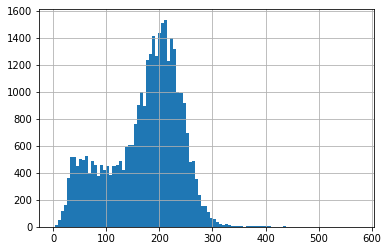

In [26]:
df.transcript.str.len().hist(bins=100)

In [6]:
idx = 0
audio_file = df.loc[idx, 'audio_file']
audio, sample_rate = librosa.load(audio_file)

In [7]:
df.loc[idx, 'transcript']

'WE WANT YOU TO HELP US PUBLISH SOME LEADING WORK OF LUTHERS FOR THE GENERAL AMERICAN MARKET WILL YOU DO IT'

In [8]:
ipd.Audio(data=audio, rate=sample_rate)

In [9]:
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128, fmax=8000)

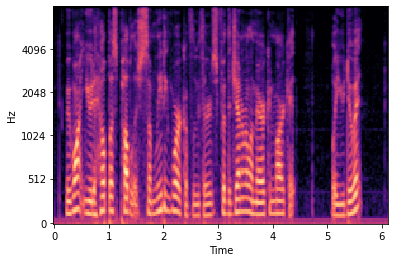

In [10]:
# Display spectrogram
librosa.display.specshow(
    librosa.power_to_db(spectrogram, ref=np.max),
    x_axis='time', y_axis='mel', fmax=8000
)

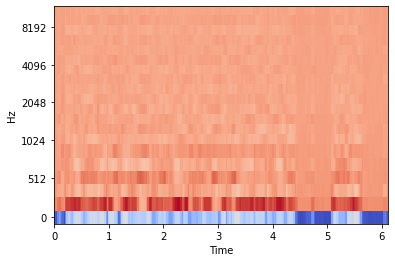

In [11]:
# Display mfccs
librosa.display.specshow(
    librosa.feature.mfcc(y=audio, sr=sample_rate),
    x_axis='time', y_axis='mel'
)

In [12]:
from torch.nn.utils.rnn import pad_sequence


def test_padding(batch):
    '''
    Check the padded audio is what we would expect
    '''
    for b in batch:
        try:
            # Check mfccs are padded correctly        
            batch_mfccs = b['mfccs']
            batch_mfcc_length = b['mfcc_length']

            audio, sample_rate = librosa.load(b['audio_file'])
            mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate)
            assert np.all(batch_mfccs[:, :batch_mfcc_length].numpy() == mfccs), 'mfccs are incorrect'

            # Check transcripts are padded correctly
            alphabet = '_ABCDEFGHIJKLMNOPQRSTUVWXYZ'
            token_indices = torch.argmax(b['tokens'], axis=1).numpy()
            token_transcript = ''.join([alphabet[ch] for ch in token_indices])
            assert token_transcript.replace('_', ' ').strip() == b['transcript'], 'transcript tokens are incorrect'
        except AssertionError as e:
            print(b)
            raise e


def pad_mfccs(batch):
    mfccs = [b['mfccs'] for b in batch]
    max_length = max(mfcc.shape[1] for mfcc in mfccs)
    res = []
    for b, mfcc in zip(batch, mfccs):
        mfcc_length = mfcc.shape[1]
        pad_size = (0, max_length - mfcc_length)
        if mfcc_length < max_length:
            mfcc = F.pad(mfcc, pad_size, 'constant', 0)
        res.append(mfcc)
    return torch.stack(res)


def pad_collate(batch, padding_value=0, test=False):
    '''
    Pad sequences in a single batch
    '''
    padded_mfccs = pad_mfccs(batch)
    padded_tokens = pad_sequence([b['tokens'] for b in batch], batch_first=True, padding_value=padding_value)
    for i, b in enumerate(batch):
        b['mfccs'] = padded_mfccs[i, :]
        b['tokens'] = padded_tokens[i, :]
    if test:
        test_padding(batch)
    return batch


class LibreSpeechDataset(Dataset):
    
    def __init__(self, directory, df, space_char='_'):
        self.directory = Path(directory)
        self.df = df
        self.space_char = space_char
        self.alphabet = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    
    def __len__(self):
        return len(list(self.directory.glob('*/*/*.flac')))
    
    def tokenizer(self, text):
        text = text.replace(' ', self.space_char)
        alphabet_dict = {ch: idx for idx, ch in enumerate([self.space_char] + self.alphabet)}
        extra_chars = ['_']
        tokens = torch.as_tensor([alphabet_dict[ch] for ch in text])
        return F.one_hot(tokens, num_classes=len(self.alphabet) + 1)

    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'audio_file']
        transcript = self.df.loc[idx, 'transcript']
        audio, sample_rate = librosa.load(audio_file)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate)
        tokens = self.tokenizer(transcript)
        return {
            'audio_file': str(audio_file), 
            'audio_length': len(audio),
            'mfccs': torch.Tensor(mfccs),
            'mfcc_length': mfccs.shape[1],
            'sample_rate': sample_rate,
            'transcript': transcript,
            'tokens': tokens,
            'num_tokens': len(tokens)
        }

In [13]:
dev_dataset = LibreSpeechDataset(directory=here('data/LibriSpeech/train-clean-100'), df=df)

In [17]:
dev_dataloader = DataLoader(
    dev_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=partial(pad_collate, test=False)
)

In [18]:
audio_file = Path('/code/data/LibriSpeech/dev-clean/2035/147960/2035-147960-0001.flac')
audio, sample_rate = librosa.load(audio_file)
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate)

In [19]:
%%time
# Check we can process all of the audio without anything falling over
for batch in tqdm(dev_dataloader):
    continue

  0%|          | 0/892 [00:00<?, ?it/s]


KeyboardInterrupt



In [22]:
batch

[{'audio_file': '/code/data/LibriSpeech/train-clean-100/458/126294/458-126294-0010.flac',
  'audio_length': 344642,
  'mfccs': tensor([[-338.1280, -304.7255, -302.9768,  ...,    0.0000,    0.0000,
              0.0000],
          [  48.6976,   56.9558,   56.9901,  ...,    0.0000,    0.0000,
              0.0000],
          [ -18.1342,  -23.7105,  -21.3940,  ...,    0.0000,    0.0000,
              0.0000],
          ...,
          [  -2.8577,    1.0351,   -1.4734,  ...,    0.0000,    0.0000,
              0.0000],
          [   8.8512,   10.3350,    7.4187,  ...,    0.0000,    0.0000,
              0.0000],
          [   8.3931,    8.5812,    9.8906,  ...,    0.0000,    0.0000,
              0.0000]]),
  'mfcc_length': 674,
  'sample_rate': 22050,
  'transcript': 'THEY MUST BE FOLLOWED INSTANTLY TO GET THEM BACK AGAIN THEN THE COOK SENT THREE SERVANTS AFTER THEM WHO WERE TO RUN AND OVERTAKE THE CHILDREN THE CHILDREN HOWEVER WERE SITTING OUTSIDE THE FOREST AND WHEN THEY SAW FROM AFAR TH